In [1]:
import torch
from time import time
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
from zipfile import ZipFile
import numpy as np
from time import time
from torchvision import datasets
from torchvision import transforms
import pandas as pd
import numpy as np
import zipfile
import re
import os
from PIL import Image
from torchvision.io import read_image
from matplotlib import image
from prepare_dataset import MyDataset,subset_generator
from utils import display_some_images,stats_of_image_and_label,MyCuda_Stats,get_output_features_of_model,display_image,display_image_transform_row
from vgg_pretrained import vgg_all_freezed,total_trainable_parameters,full_vgg,vgg_layer_freeze
from Model import Network,new_model
from Transform import Transform
from train_fn import train,validation,image_validation,validation_classes,train_w_transform
from tqdm import tqdm
from sklearn.metrics import classification_report


D:\anaconda\envs\affectnet2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
fullvgg=full_vgg()
total_trainable_parameters(fullvgg)
total_trainable_parameters(fullvgg.features)
total_trainable_parameters(vgg_all_freezed())
total_trainable_parameters(vgg_layer_freeze(24))


Total trainable parameters of VGG is 	 138357544

Total trainable parameters of Sequential is 	 14714688

Total trainable parameters of Sequential is 	 0

Total trainable parameters of Sequential is 	 7079424


In [3]:
# DATA LOADER PARAMETERS
batch=64
CUDA_LAUNCH_BLOCKING=1 

In [4]:
MyCuda_Stats()

No of GPUs i have is 1
0
My Graphic Card is NVIDIA GeForce RTX 2070 SUPER
Is Cuda Available True


In [5]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform = transforms.Compose([transforms.ToTensor(),normalize])
target_transform=transforms.Compose([transforms.ToTensor()])

In [6]:
anno_dir=r"./01_data/train_set/annotations"
image_dir=r"./01_data/train_set/images"
train_data=MyDataset(anno_dir,image_dir,transform=transform, target_transform=None)

In [7]:
val_anno_dir=r"./01_data/val_set/annotations"
val_image_dir=r"./01_data/val_set/images"
val_data=MyDataset(val_anno_dir,val_image_dir,transform=transform, target_transform=None)

In [8]:
Subset_train_sampler=subset_generator(train_data,5000)

In [9]:
train_loader=torch.utils.data.DataLoader(train_data,
                                         batch_size=batch,
                                         shuffle=False,
                                         num_workers=4,
                                         pin_memory=True,
                                         sampler=None)
val_loader=torch.utils.data.DataLoader(val_data,
                                       batch_size=batch,
                                       shuffle=False,
                                       num_workers=4,
                                       pin_memory=True,
                                      sampler=None)
val_loader_class=torch.utils.data.DataLoader(val_data,
                                       batch_size=1,
                                       shuffle=False,
                                       num_workers=4,
                                       pin_memory=True,
                                      sampler=None)

In [10]:
print(len(train_loader))
print(len(val_loader))


4495
63


In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [12]:
feature_extractor=vgg_layer_freeze(17)
total_trainable_parameters(feature_extractor)



Total trainable parameters of Sequential is 	 12979200


In [13]:

#input_features_for_denselayer=get_output_features_of_model(model=feature_extractor,batch_size=32,dataloader=train_loader)
input_features_for_denselayer=25088


In [14]:
t_image=Transform(input_features_for_denselayer)
model1=new_model(feature_extractor,input_features_for_denselayer).to(device)
model1

new_model(
  (extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dil

In [15]:
total_trainable_parameters(model1)


Total trainable parameters of new_model is 	 115776520


In [24]:
lr=0.0001
weights=[0.1,0.1,0.5,0.5,0.8,0.99,0.5,0.99]
loss1=nn.CrossEntropyLoss(weight=torch.tensor(weights).to(device))
#optimizer=optim.Adam(model1.parameters(),lr)

#weights=[0.71,0.77,0.93,0.94,0.94,0.94,0.93,0.94]
#loss1=nn.CrossEntropyLoss()#weight=torch.tensor(weights).to(device)
#loss_plain=nn.CrossEntropyLoss()
optimizer=optim.SGD(model1.parameters(),lr=0.0001,momentum=0,weight_decay=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

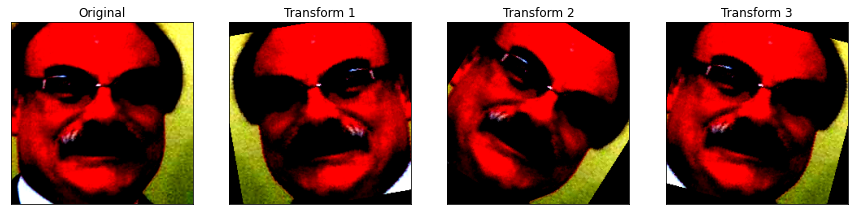

In [17]:
display_image_transform_row(train_data[0][0],t_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


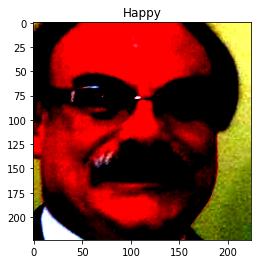

In [18]:
display_image(train_data[0][0],train_data[0][1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


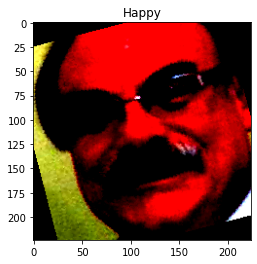

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


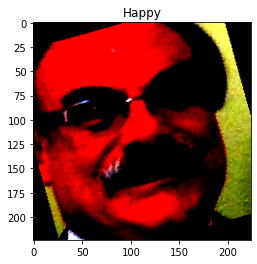

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


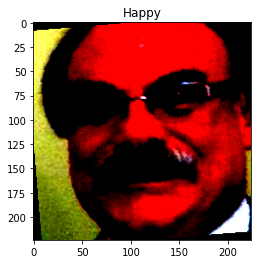

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


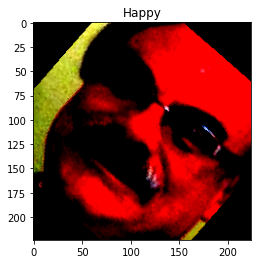

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


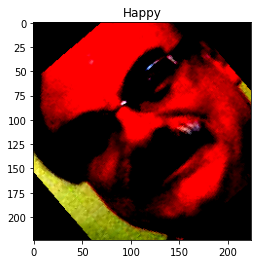

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


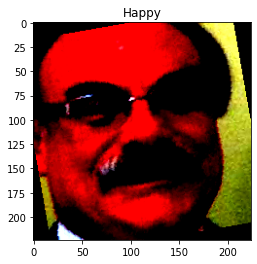

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


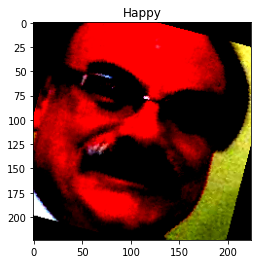

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


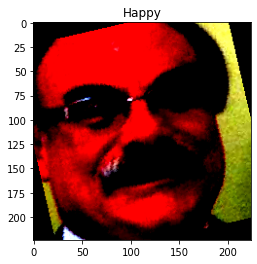

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


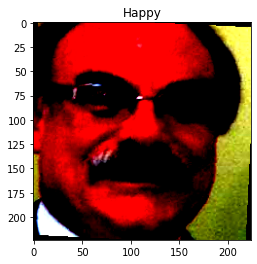

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


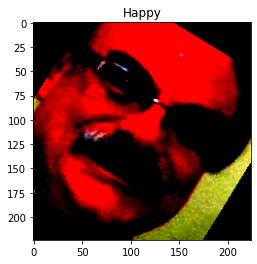

In [19]:
for _ in range(10):
    display_image(t_image.tran(train_data[0][0]),train_data[0][1])

In [20]:
model1.load_state_dict(torch.load(r"./01_data/modelrecent.pth"))

<All keys matched successfully>

In [21]:
#optimizer.load_state_dict(torch.load(r"C:\Users\DELL\Desktop\Python\Affect_Net\Affectnet\models\optimizer1.pth"))

In [22]:
val_loader_class=torch.utils.data.DataLoader(val_data,
                                       batch_size=1,
                                       shuffle=False,
                                       num_workers=4,
                                       pin_memory=True,
                                      sampler=None)

In [23]:
classes=['Neutral','Happy','Sad','Surprise','Fear','Disgust','Anger','Contempt']


In [33]:
print(len(train_data))

287651


In [24]:
c_dict={}
for c in classes:
    c_dict[c]=0
for _,(image,label) in enumerate(tqdm(train_data)):
    #print(label)
    c_dict[classes[int(label)]]+=1
print(c_dict)

100%|██████████| 287651/287651 [09:31<00:00, 503.56it/s]

{'Neutral': 74874, 'Happy': 134415, 'Sad': 25459, 'Surprise': 14090, 'Fear': 6378, 'Disgust': 3803, 'Anger': 24882, 'Contempt': 3750}


In [24]:
train_data.upsample()

Finding Class Counts...


100%|██████████| 287651/287651 [03:02<00:00, 1577.19it/s]


Balancing Class: Neutral


0it [00:00, ?it/s]


Balancing Class: Happy


0it [00:00, ?it/s]


Balancing Class: Sad


0it [00:00, ?it/s]


Balancing Class: Surprise


100%|██████████| 5910/5910 [00:01<00:00, 4233.72it/s]


Balancing Class: Fear


100%|██████████| 13622/13622 [00:03<00:00, 4287.18it/s]


Balancing Class: Disgust


100%|██████████| 16197/16197 [00:03<00:00, 4342.05it/s]


Balancing Class: Anger


0it [00:00, ?it/s]


Balancing Class: Contempt


100%|██████████| 16250/16250 [00:03<00:00, 4337.97it/s]


In [35]:
c_dict={}
for c in classes:
    c_dict[c]=0
for _,(image,label) in enumerate(tqdm(train_data)):
    #print(label)
    c_dict[classes[int(label)]]+=1
print(c_dict)

100%|██████████| 339630/339630 [10:19<00:00, 548.62it/s]

{'Neutral': 74874, 'Happy': 134415, 'Sad': 25459, 'Surprise': 20000, 'Fear': 20000, 'Disgust': 20000, 'Anger': 24882, 'Contempt': 20000}


In [26]:
len(train_data)

339630

In [25]:
validation(val_loader,model1,loss1)

100%|██████████| 63/63 [00:29<00:00,  2.11it/s]

test error-2.272154 
 Accuracy-48.012003%


In [26]:
validation_classes(val_loader_class,model1,loss1,0)

100%|██████████| 3999/3999 [00:16<00:00, 248.26it/s]

test error-0.701502 
 Accuracy-76.800000%


In [27]:
validation_classes(val_loader_class,model1,loss1,1)

100%|██████████| 3999/3999 [00:13<00:00, 292.79it/s]

test error-0.345160 
 Accuracy-89.200000%


In [28]:
validation_classes(val_loader_class,model1,loss1,2)

100%|██████████| 3999/3999 [00:13<00:00, 291.81it/s]

test error-1.427453 
 Accuracy-51.600000%


In [29]:
validation_classes(val_loader_class,model1,loss1,3)

100%|██████████| 3999/3999 [00:13<00:00, 293.36it/s]

test error-2.318290 
 Accuracy-41.600000%


In [30]:
validation_classes(val_loader_class,model1,loss1,4)

100%|██████████| 3999/3999 [00:13<00:00, 286.38it/s]

test error-2.487224 
 Accuracy-36.400000%


In [31]:
validation_classes(val_loader_class,model1,loss1,5)

100%|██████████| 3999/3999 [00:13<00:00, 286.15it/s]

test error-4.057422 
 Accuracy-26.000000%


In [32]:
validation_classes(val_loader_class,model1,loss1,6)

100%|██████████| 3999/3999 [00:13<00:00, 292.81it/s]

test error-1.685344 
 Accuracy-54.000000%


In [33]:
validation_classes(val_loader_class,model1,loss1,7)

100%|██████████| 3999/3999 [00:13<00:00, 291.73it/s]

test error-4.069240 
 Accuracy-8.416834%


In [25]:
# NO OF EPOCHS IS 5
epochs=3
for epoch in range(epochs):
    print(f'Epoch-{epoch}')
    train_w_transform(train_loader,model1,loss1,optimizer,t_image)
    validation(val_loader,model1,loss1)
    print(classes[0])
    validation_classes(val_loader_class,model1,loss1,0)
    print(classes[1])
    validation_classes(val_loader_class,model1,loss1,1)
    print(classes[2])
    validation_classes(val_loader_class,model1,loss1,2)
    print(classes[3])
    validation_classes(val_loader_class,model1,loss1,3)
    print(classes[4])
    validation_classes(val_loader_class,model1,loss1,4)
    print(classes[5])
    validation_classes(val_loader_class,model1,loss1,5)
    print(classes[6])
    validation_classes(val_loader_class,model1,loss1,6)
    print(classes[7])
    validation_classes(val_loader_class,model1,loss1,7)
    

Epoch-0


100%|██████████| 4495/4495 [20:52<00:00,  3.59it/s]


loss:0.908348 batch:4494/4495


100%|██████████| 63/63 [00:23<00:00,  2.71it/s]


test error-1.627070 
 Accuracy-51.462866%
Neutral


100%|██████████| 3999/3999 [00:14<00:00, 284.82it/s]


test error-1.271011 
 Accuracy-51.600000%
Happy


100%|██████████| 3999/3999 [00:13<00:00, 302.95it/s]


test error-0.410861 
 Accuracy-89.600000%
Sad


100%|██████████| 3999/3999 [00:13<00:00, 291.70it/s]


test error-0.946420 
 Accuracy-64.200000%
Surprise


100%|██████████| 3999/3999 [00:14<00:00, 283.26it/s]


test error-1.355109 
 Accuracy-51.600000%
Fear


100%|██████████| 3999/3999 [00:13<00:00, 287.92it/s]


test error-1.376792 
 Accuracy-47.000000%
Disgust


100%|██████████| 3999/3999 [00:13<00:00, 288.55it/s]


test error-2.138371 
 Accuracy-29.400000%
Anger


100%|██████████| 3999/3999 [00:14<00:00, 279.40it/s]


test error-1.029437 
 Accuracy-64.800000%
Contempt


100%|██████████| 3999/3999 [00:13<00:00, 304.09it/s]


test error-2.254960 
 Accuracy-13.426854%
Epoch-1


100%|██████████| 4495/4495 [20:20<00:00,  3.68it/s]


loss:1.192893 batch:4494/4495


100%|██████████| 63/63 [00:22<00:00,  2.81it/s]


test error-1.604024 
 Accuracy-51.562891%
Neutral


100%|██████████| 3999/3999 [00:13<00:00, 301.25it/s]


test error-1.312408 
 Accuracy-47.600000%
Happy


100%|██████████| 3999/3999 [00:13<00:00, 301.10it/s]


test error-0.393679 
 Accuracy-89.000000%
Sad


100%|██████████| 3999/3999 [00:13<00:00, 300.40it/s]


test error-0.910834 
 Accuracy-65.600000%
Surprise


100%|██████████| 3999/3999 [00:13<00:00, 302.74it/s]


test error-1.336813 
 Accuracy-51.200000%
Fear


100%|██████████| 3999/3999 [00:13<00:00, 300.42it/s]


test error-1.290346 
 Accuracy-51.400000%
Disgust


100%|██████████| 3999/3999 [00:13<00:00, 303.80it/s]


test error-2.088237 
 Accuracy-31.800000%
Anger


100%|██████████| 3999/3999 [00:13<00:00, 301.78it/s]


test error-1.020874 
 Accuracy-65.000000%
Contempt


100%|██████████| 3999/3999 [00:13<00:00, 302.18it/s]


test error-2.302101 
 Accuracy-10.821643%
Epoch-2


100%|██████████| 4495/4495 [20:20<00:00,  3.68it/s]


loss:1.383140 batch:4494/4495


100%|██████████| 63/63 [00:22<00:00,  2.77it/s]


test error-1.591472 
 Accuracy-51.962991%
Neutral


100%|██████████| 3999/3999 [00:13<00:00, 303.53it/s]


test error-1.317488 
 Accuracy-47.000000%
Happy


100%|██████████| 3999/3999 [00:13<00:00, 301.96it/s]


test error-0.389364 
 Accuracy-88.600000%
Sad


100%|██████████| 3999/3999 [00:13<00:00, 305.96it/s]


test error-0.891987 
 Accuracy-65.600000%
Surprise


100%|██████████| 3999/3999 [00:13<00:00, 302.12it/s]


test error-1.339350 
 Accuracy-51.200000%
Fear


100%|██████████| 3999/3999 [00:14<00:00, 283.75it/s]


test error-1.304102 
 Accuracy-51.600000%
Disgust


100%|██████████| 3999/3999 [00:13<00:00, 303.48it/s]


test error-2.091095 
 Accuracy-31.800000%
Anger


100%|██████████| 3999/3999 [00:13<00:00, 305.43it/s]


test error-1.007852 
 Accuracy-65.600000%
Contempt


100%|██████████| 3999/3999 [00:13<00:00, 296.96it/s]

test error-2.247636 
 Accuracy-14.228457%


In [26]:
torch.save(model1.state_dict(), r".\dirtyweights.pth")

In [ ]:
torch.save(optimizer.state_dict(), r"C:\Users\DELL\Desktop\Python\Affect_Net\Affectnet\models\optimizerrecent.pth")

In [25]:
torch.cuda.empty_cache()

In [ ]:
torch.cuda.memory_summary(device='cuda', abbreviated=True)